# Packages

In [77]:
! pip install lifelines scikit-survival survshap shap jinja2 survinsights seaborn numpy==1.23.5 

Defaulting to user installation because normal site-packages is not writeable


In [78]:
! pip install numba 

Defaulting to user installation because normal site-packages is not writeable


In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
import survshap
import seaborn as sns 
import survinsights

from sksurv.util import Surv
from sksurv.metrics import brier_score
from sksurv.ensemble import RandomSurvivalForest
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.metrics import integrated_brier_score
from sksurv.metrics import concordance_index_censored
from lifelines import CoxPHFitter
from lifelines import KaplanMeierFitter
from sklearn.model_selection import train_test_split
from survinsights import local_explaination
from sklearn.preprocessing import LabelEncoder
#from survlimepy import SurvLimeExplainer

import time

import numba
import numpy as np
import sklearn.ensemble

import shap

import matplotlib.pyplot as plt
from sksurv.datasets import load_whas500
from sksurv.ensemble import RandomSurvivalForest
from sklearn.model_selection import train_test_split
from lifelines import KaplanMeierFitter
import numpy as np
import itertools
import random
from survinsights import local_explaination
from survinsights.explainer import explainer
from tqdm import tqdm

from scipy.integrate import simpson

# Données

In [80]:
data = pd.read_csv("METABRIC_RNA_Mutation.csv")
data

/tmp/ipykernel_35020/1434437314.py:1: DtypeWarning: Columns (678,688,690,692) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("METABRIC_RNA_Mutation.csv")


,patient_id,age_at_diagnosis,type_of_breast_surgery,cancer_type,cancer_type_detailed,cellularity,chemotherapy,pam50_+_claudin-low_subtype,cohort,er_status_measured_by_ihc,...,mtap_mut,ppp2cb_mut,smarcd1_mut,nras_mut,ndfip1_mut,hras_mut,prps2_mut,smarcb1_mut,stmn2_mut,siah1_mut
0,0,75.65,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,NaN,0,claudin-low,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0
1,2,43.19,BREAST CONSERVING,Breast Cancer,Breast Invasive Ductal Carcinoma,High,0,LumA,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0
2,5,48.87,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,High,1,LumB,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0
3,6,47.68,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,Moderate,1,LumB,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0
4,8,76.97,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,High,1,LumB,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1899,7295,43.10,BREAST CONSERVING,Breast Cancer,Breast Invasive Lobular Carcinoma,High,0,LumA,4.0,Positve,...,0,0,0,0,0,0,0,0,0,0
1900,7296,42.88,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,High,0,LumB,4.0,Positve,...,0,0,0,0,0,0,0,0,0,0
1901,7297,62.90,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,High,0,LumB,4.0,Positve,...,0,0,0,0,0,0,0,0,0,0
1902,7298,61.16,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,Moderate,0,LumB,4.0,Positve,...,0,0,0,0,0,0,0,0,0,0


In [81]:
colones_00 = data.columns[520:]  # colones dont on veut faire passer 0 à "0", a partir de la colone "pik3ca_mut"
data[colones_00] = data[colones_00].astype(str)
data[colones_00] = data[colones_00].applymap(lambda x: 0 if x == "0" else 1)

/tmp/ipykernel_35020/1479749344.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  data[colones_00] = data[colones_00].applymap(lambda x: 0 if x == "0" else 1)


In [82]:
for col in data.select_dtypes(include=['object']).columns:
    data[col] = LabelEncoder().fit_transform(data[col])

In [83]:
y = data[["death_from_cancer", "overall_survival_months"]]
y['Died_of_Desease'] = (y['death_from_cancer'] == 0).astype(int)
y=y.drop("death_from_cancer", axis=1)
y.head()

/tmp/ipykernel_35020/1315501560.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['Died_of_Desease'] = (y['death_from_cancer'] == 0).astype(int)


,overall_survival_months,Died_of_Desease
0,140.500000,0
1,84.633333,0
2,163.700000,1
3,164.933333,0
4,41.366667,1


In [84]:
X = data.drop(columns=["death_from_cancer", "overall_survival_months", "overall_survival"]) 

# RSF

In [85]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [86]:
y_train_RSF = Surv.from_dataframe("Died_of_Desease", "overall_survival_months", y_train)
y_test_RSF = Surv.from_dataframe("Died_of_Desease", "overall_survival_months", y_test)

In [87]:
rsf = RandomSurvivalForest(n_estimators=100, random_state=42,max_depth=11)
rsf.fit(X_train, y_train_RSF)

RandomSurvivalForest(max_depth=11, random_state=42)

## Performance

In [88]:
times = np.arange(2, 337)

In [89]:
# Prédire les fonctions de survie
survs = rsf.predict_survival_function(X_test)

preds = np.asarray([[fn(t) for t in times] for fn in survs])
score = integrated_brier_score(y_train_RSF, y_test_RSF, preds, times)
print(score)

0.163569163435151


# Survtreeshap

## Fonction

In [90]:
#au t-ième moment 

class TreeExplainer:
    def __init__(self, model, t=0, **kwargs):
        if str(type(model)).endswith("sklearn.ensemble._forest.RandomForestRegressor'>") or 1==1: #attention
            # self.trees = [Tree(e.tree_) for e in model.estimators_]
            self.trees = [
                Tree(
                    children_left=e.tree_.children_left,
                    children_right=e.tree_.children_right,
                    children_default=e.tree_.children_right,
                    feature=e.tree_.feature,
                    threshold=e.tree_.threshold,
                    value=e.tree_.value[:, t, 1],
                    node_sample_weight=e.tree_.weighted_n_node_samples,
                )
                for e in model.estimators_
            ]

        # Preallocate space for the unique path data
        maxd = np.max([t.max_depth for t in self.trees]) + 2
        s = (maxd * (maxd + 1)) // 2
        self.feature_indexes = np.zeros(s, dtype=np.int32)
        self.zero_fractions = np.zeros(s, dtype=np.float64)
        self.one_fractions = np.zeros(s, dtype=np.float64)
        self.pweights = np.zeros(s, dtype=np.float64)

    def shap_values(self, X, **kwargs):
        # convert dataframes
        if str(type(X)).endswith("pandas.core.series.Series'>"):
            X = X.values
        elif str(type(X)).endswith("'pandas.core.frame.DataFrame'>"):
            X = X.values

        assert str(type(X)).endswith("'numpy.ndarray'>"), "Unknown instance type: " + str(type(X))
        assert len(X.shape) == 1 or len(X.shape) == 2, "Instance must have 1 or 2 dimensions!"

        # single instance
        if len(X.shape) == 1:
            phi = np.zeros(X.shape[0] + 1)
            x_missing = np.zeros(X.shape[0], dtype=bool)
            for t in self.trees:
                self.tree_shap(t, X, x_missing, phi)
            phi /= len(self.trees)
        elif len(X.shape) == 2:
            phi = np.zeros((X.shape[0], X.shape[1] + 1))
            x_missing = np.zeros(X.shape[1], dtype=bool)
            for i in range(X.shape[0]):
                for t in self.trees:
                    self.tree_shap(t, X[i, :], x_missing, phi[i, :])
            phi /= len(self.trees)
        return phi

    def tree_shap(self, tree, x, x_missing, phi, condition=0, condition_feature=0):
        # update the bias term, which is the last index in phi
        # (note the paper has this as phi_0 instead of phi_M)
        if condition == 0:
            phi[-1] += tree.values[0]

        # start the recursive algorithm
        tree_shap_recursive(
            tree.children_left,
            tree.children_right,
            tree.children_default,
            tree.features,
            tree.thresholds,
            tree.values,
            tree.node_sample_weight,
            x,
            x_missing,
            phi,
            0,
            0,
            self.feature_indexes,
            self.zero_fractions,
            self.one_fractions,
            self.pweights,
            1,
            1,
            -1,
            condition,
            condition_feature,
            1,
        )

In [91]:
# extend our decision path with a fraction of one and zero extensions
@numba.jit(
    numba.types.void(
        numba.types.int32[:],
        numba.types.float64[:],
        numba.types.float64[:],
        numba.types.float64[:],
        numba.types.int32,
        numba.types.float64,
        numba.types.float64,
        numba.types.int32,
    ),
    nopython=True,
    nogil=True,
)
def extend_path(
    feature_indexes,
    zero_fractions,
    one_fractions,
    pweights,
    unique_depth,
    zero_fraction,
    one_fraction,
    feature_index,
):
    feature_indexes[unique_depth] = feature_index
    zero_fractions[unique_depth] = zero_fraction
    one_fractions[unique_depth] = one_fraction
    if unique_depth == 0:
        pweights[unique_depth] = 1
    else:
        pweights[unique_depth] = 0

    for i in range(unique_depth - 1, -1, -1):
        pweights[i + 1] += one_fraction * pweights[i] * (i + 1) / (unique_depth + 1)
        pweights[i] = zero_fraction * pweights[i] * (unique_depth - i) / (unique_depth + 1)


# undo a previous extension of the decision path
@numba.jit(
    numba.types.void(
        numba.types.int32[:],
        numba.types.float64[:],
        numba.types.float64[:],
        numba.types.float64[:],
        numba.types.int32,
        numba.types.int32,
    ),
    nopython=True,
    nogil=True,
)
def unwind_path(feature_indexes, zero_fractions, one_fractions, pweights, unique_depth, path_index):
    one_fraction = one_fractions[path_index]
    zero_fraction = zero_fractions[path_index]
    next_one_portion = pweights[unique_depth]

    for i in range(unique_depth - 1, -1, -1):
        if one_fraction != 0:
            tmp = pweights[i]
            pweights[i] = next_one_portion * (unique_depth + 1) / ((i + 1) * one_fraction)
            next_one_portion = tmp - pweights[i] * zero_fraction * (unique_depth - i) / (unique_depth + 1)
        else:
            pweights[i] = (pweights[i] * (unique_depth + 1)) / (zero_fraction * (unique_depth - i))

    for i in range(path_index, unique_depth):
        feature_indexes[i] = feature_indexes[i + 1]
        zero_fractions[i] = zero_fractions[i + 1]
        one_fractions[i] = one_fractions[i + 1]


# determine what the total permuation weight would be if
# we unwound a previous extension in the decision path
@numba.jit(
    numba.types.float64(
        numba.types.int32[:],
        numba.types.float64[:],
        numba.types.float64[:],
        numba.types.float64[:],
        numba.types.int32,
        numba.types.int32,
    ),
    nopython=True,
    nogil=True,
)
def unwound_path_sum(feature_indexes, zero_fractions, one_fractions, pweights, unique_depth, path_index):
    one_fraction = one_fractions[path_index]
    zero_fraction = zero_fractions[path_index]
    next_one_portion = pweights[unique_depth]
    total = 0

    for i in range(unique_depth - 1, -1, -1):
        if one_fraction != 0:
            tmp = next_one_portion * (unique_depth + 1) / ((i + 1) * one_fraction)
            total += tmp
            next_one_portion = pweights[i] - tmp * zero_fraction * ((unique_depth - i) / (unique_depth + 1))
        else:
            total += (pweights[i] / zero_fraction) / ((unique_depth - i) / (unique_depth + 1))

    return total


class Tree:
    def __init__(
        self,
        children_left,
        children_right,
        children_default,
        feature,
        threshold,
        value,
        node_sample_weight,
    ):
        self.children_left = children_left.astype(np.int32)
        self.children_right = children_right.astype(np.int32)
        self.children_default = children_default.astype(np.int32)
        self.features = feature.astype(np.int32)
        self.thresholds = threshold
        self.values = value
        self.node_sample_weight = node_sample_weight

        self.max_depth = compute_expectations(
            self.children_left,
            self.children_right,
            self.node_sample_weight,
            self.values,
            0,
        )


@numba.jit(nopython=True)
def compute_expectations(children_left, children_right, node_sample_weight, values, i, depth=0):
    if children_right[i] == -1:
        values[i] = values[i]
        return 0
    else:
        li = children_left[i]
        ri = children_right[i]
        depth_left = compute_expectations(children_left, children_right, node_sample_weight, values, li, depth + 1)
        depth_right = compute_expectations(children_left, children_right, node_sample_weight, values, ri, depth + 1)
        left_weight = node_sample_weight[li]
        right_weight = node_sample_weight[ri]
        v = (left_weight * values[li] + right_weight * values[ri]) / (left_weight + right_weight)
        values[i] = v
        return max(depth_left, depth_right) + 1


# recursive computation of SHAP values for a decision tree
@numba.jit(
    numba.types.void(
        numba.types.int32[:],
        numba.types.int32[:],
        numba.types.int32[:],
        numba.types.int32[:],
        numba.types.float64[:],
        numba.types.float64[:],
        numba.types.float64[:],
        numba.types.float64[:],
        numba.types.boolean[:],
        numba.types.float64[:],
        numba.types.int64,
        numba.types.int64,
        numba.types.int32[:],
        numba.types.float64[:],
        numba.types.float64[:],
        numba.types.float64[:],
        numba.types.float64,
        numba.types.float64,
        numba.types.int64,
        numba.types.int64,
        numba.types.int64,
        numba.types.float64,
    ),
    nopython=True,
    nogil=True,
)
def tree_shap_recursive(
    children_left,
    children_right,
    children_default,
    features,
    thresholds,
    values,
    node_sample_weight,
    x,
    x_missing,
    phi,
    node_index,
    unique_depth,
    parent_feature_indexes,
    parent_zero_fractions,
    parent_one_fractions,
    parent_pweights,
    parent_zero_fraction,
    parent_one_fraction,
    parent_feature_index,
    condition,
    condition_feature,
    condition_fraction,
):
    # stop if we have no weight coming down to us
    if condition_fraction == 0:
        return

    # extend the unique path
    feature_indexes = parent_feature_indexes[unique_depth + 1 :]
    feature_indexes[: unique_depth + 1] = parent_feature_indexes[: unique_depth + 1]
    zero_fractions = parent_zero_fractions[unique_depth + 1 :]
    zero_fractions[: unique_depth + 1] = parent_zero_fractions[: unique_depth + 1]
    one_fractions = parent_one_fractions[unique_depth + 1 :]
    one_fractions[: unique_depth + 1] = parent_one_fractions[: unique_depth + 1]
    pweights = parent_pweights[unique_depth + 1 :]
    pweights[: unique_depth + 1] = parent_pweights[: unique_depth + 1]

    if condition == 0 or condition_feature != parent_feature_index:
        extend_path(
            feature_indexes,
            zero_fractions,
            one_fractions,
            pweights,
            unique_depth,
            parent_zero_fraction,
            parent_one_fraction,
            parent_feature_index,
        )

    split_index = features[node_index]

    # leaf node
    if children_right[node_index] == -1:
        for i in range(1, unique_depth + 1):
            w = unwound_path_sum(
                feature_indexes,
                zero_fractions,
                one_fractions,
                pweights,
                unique_depth,
                i,
            )
            phi[feature_indexes[i]] += (
                w * (one_fractions[i] - zero_fractions[i]) * values[node_index] * condition_fraction
            )

    # internal node
    else:
        # find which branch is "hot" (meaning x would follow it)
        hot_index = 0
        cleft = children_left[node_index]
        cright = children_right[node_index]
        if x_missing[split_index] == 1:
            hot_index = children_default[node_index]
        elif x[split_index] < thresholds[node_index]:
            hot_index = cleft
        else:
            hot_index = cright
        cold_index = cright if hot_index == cleft else cleft
        w = node_sample_weight[node_index]
        hot_zero_fraction = node_sample_weight[hot_index] / w
        cold_zero_fraction = node_sample_weight[cold_index] / w
        incoming_zero_fraction = 1
        incoming_one_fraction = 1

        # see if we have already split on this feature,
        # if so we undo that split so we can redo it for this node
        path_index = 0
        while path_index <= unique_depth:
            if feature_indexes[path_index] == split_index:
                break
            path_index += 1

        if path_index != unique_depth + 1:
            incoming_zero_fraction = zero_fractions[path_index]
            incoming_one_fraction = one_fractions[path_index]
            unwind_path(
                feature_indexes,
                zero_fractions,
                one_fractions,
                pweights,
                unique_depth,
                path_index,
            )
            unique_depth -= 1

        # divide up the condition_fraction among the recursive calls
        hot_condition_fraction = condition_fraction
        cold_condition_fraction = condition_fraction
        if condition > 0 and split_index == condition_feature:
            cold_condition_fraction = 0
            unique_depth -= 1
        elif condition < 0 and split_index == condition_feature:
            hot_condition_fraction *= hot_zero_fraction
            cold_condition_fraction *= cold_zero_fraction
            unique_depth -= 1

        tree_shap_recursive(
            children_left,
            children_right,
            children_default,
            features,
            thresholds,
            values,
            node_sample_weight,
            x,
            x_missing,
            phi,
            hot_index,
            unique_depth + 1,
            feature_indexes,
            zero_fractions,
            one_fractions,
            pweights,
            hot_zero_fraction * incoming_zero_fraction,
            incoming_one_fraction,
            split_index,
            condition,
            condition_feature,
            hot_condition_fraction,
        )

        tree_shap_recursive(
            children_left,
            children_right,
            children_default,
            features,
            thresholds,
            values,
            node_sample_weight,
            x,
            x_missing,
            phi,
            cold_index,
            unique_depth + 1,
            feature_indexes,
            zero_fractions,
            one_fractions,
            pweights,
            cold_zero_fraction * incoming_zero_fraction,
            0,
            split_index,
            condition,
            condition_feature,
            cold_condition_fraction,
        )

## Résultat

In [99]:
id_patient=0

In [ ]:
unique_times = rsf.estimators_[0].unique_times_
x = np.array(unique_times)
y = np.array([
    TreeExplainer(rsf,t=i).shap_values(X_test.iloc[id_patient, :])
    for i in range(len(unique_times))
    ])

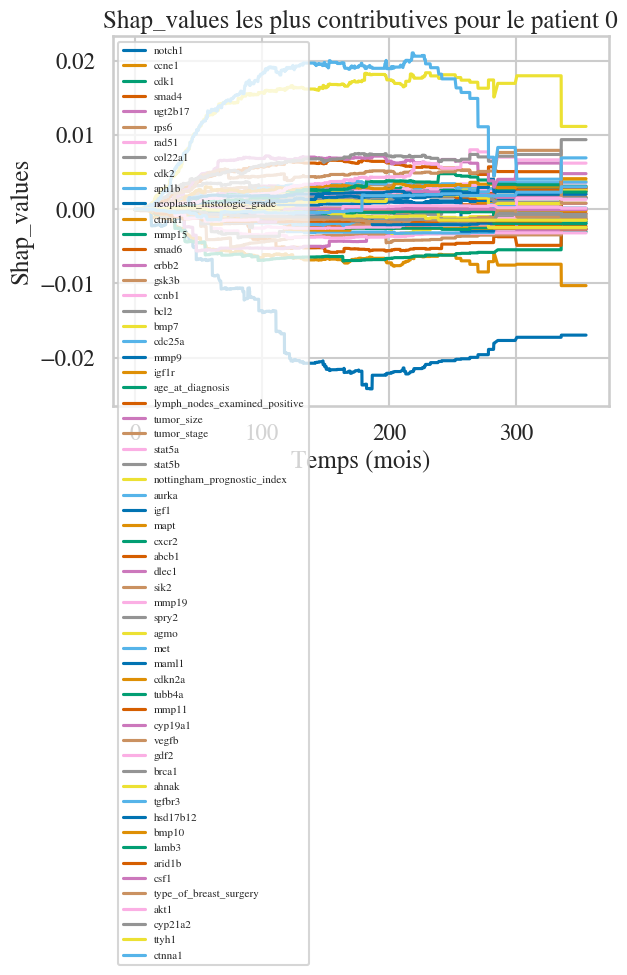

In [100]:
top_values= [y[:,i].max() for i in range(len(y[1])-1)]
top_indices = np.argsort(top_values)[-30:]
bot_values= [y[:,i].min() for i in range(len(y[1])-1)]
bot_indices = np.argsort(bot_values)[:30]

indices=np.concatenate((top_indices, bot_indices))

y_plot=np.array([y[:,i] for i in indices]).T
legend=[X.columns[i] for i in indices]


plt.plot(x,y_plot,label=legend)

# Ajouter des labels et une légende
plt.xlabel("Temps (mois)")
plt.ylabel("Shap_values")
plt.title(f"Shap_values les plus contributives pour le patient {id_patient}")
plt.legend(loc="upper left",fontsize=8)

# Afficher le graphique
plt.show()